In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.interpolate import LinearNDInterpolator
from tqdm import tqdm

In [2]:
ds = xr.open_dataset("combined_output_freq_c_1_wave_only_vary_y.nc", decode_times=False)

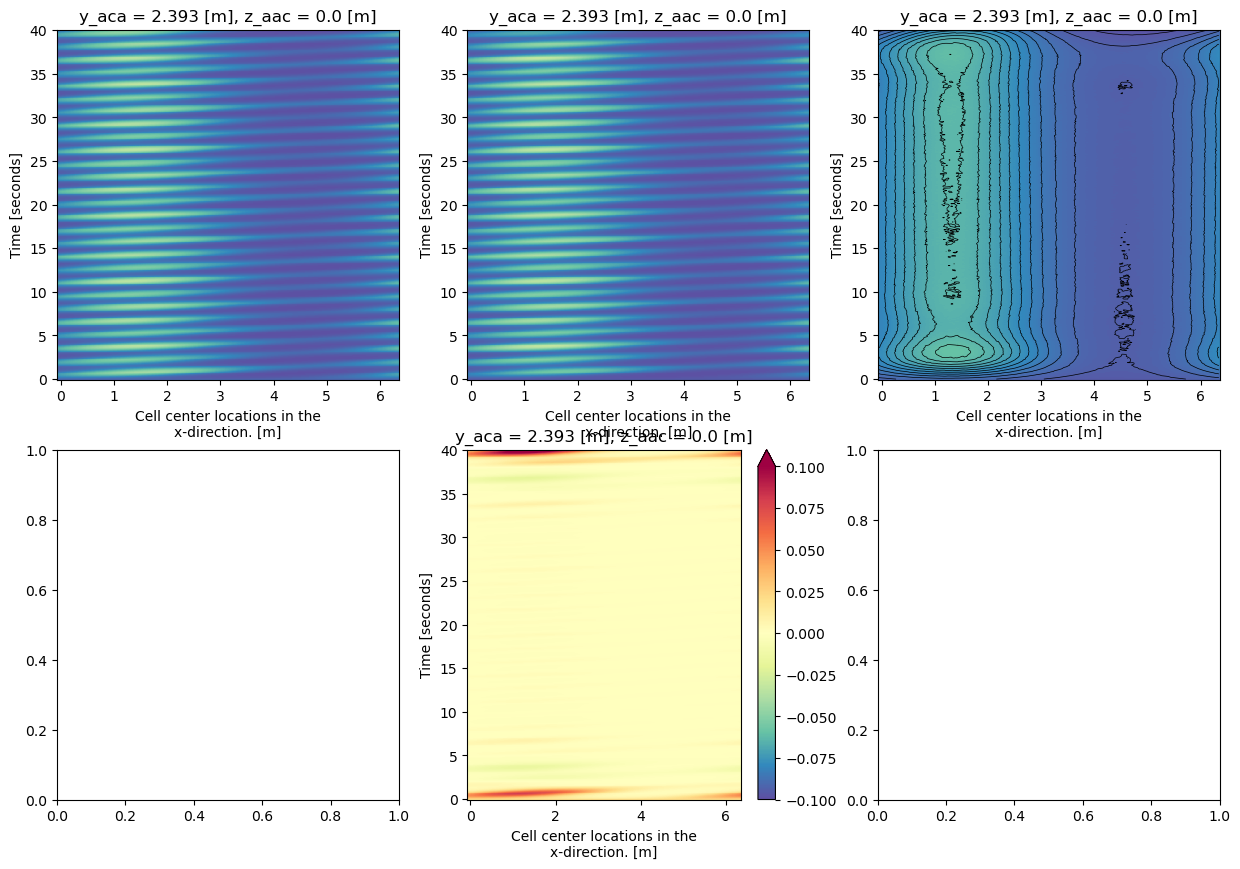

In [7]:
fig, ax = plt.subplots(2,3,figsize = (15,10))
ds.T[:,0,100,:].plot(ax=ax[0,0],vmin = 0, vmax = 1,add_colorbar=False,cmap='Spectral_r')
# ds.T[:,0,100,:].plot.contour(ax=ax[0,0],levels=20,colors='black',linewidths=0.5)
ds.T_filtered[:,0,100,:].plot(ax=ax[0,1],vmin = 0, vmax = 1,add_colorbar=False,cmap='Spectral_r')
# ds.T_filtered[:,0,100,:].plot.contour(ax=ax[0,1],levels=20,colors='black',linewidths=0.5)
ds.T_filtered_regrid[:,0,100,:].plot(ax=ax[0,2],vmin = 0, vmax = 1,add_colorbar=False,cmap='Spectral_r')
ds.T_filtered_regrid[:,0,100,:].plot.contour(ax=ax[0,2],levels=20,colors='black',linewidths=0.5)
# ds.T_filtered_regrid_python[:,0,100,:].plot(ax=ax[1,0],vmin = 0, vmax = 1,add_colorbar=False,cmap='Spectral_r')
# ds.T_filtered_regrid_python[:,0,100,:].plot.contour(ax=ax[1,0],levels=40,colors='black',linewidths=0.5)
(ds.T - ds.T_filtered)[:,0,100,:].plot(ax=ax[1,1],vmin = -0.1, vmax = 0.1,cmap='Spectral_r')
#(ds.T_filtered_regrid - ds.T_filtered_regrid_python)[:,0,100,:].plot(ax=ax[1,2],vmin = -0.1, vmax = 0.1,cmap='Spectral_r')

In [49]:
ds.to_netcdf("combined_output_freq_c_1_wave_only_vary_x_with_python_regrid.nc")

(0.8, 1.0)

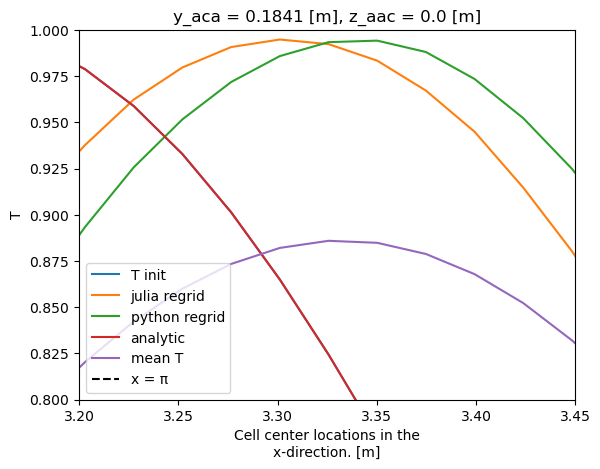

In [48]:
# Stokes drift from direction of waves!
width = 2*np.pi/15
ds.T[0,0,10,:].plot(label='T init')
ds.T_filtered_regrid[200,0,10,:].plot(label='julia regrid')
ds.T_filtered_regrid_python[200,0,10,:].plot(label='python regrid')
plt.plot(ds.x_caa, np.exp(-((ds.x_caa - np.pi)/width)**2), label='analytic')
ds.T[:,0,10,:].mean(axis=0).plot(label='mean T')
plt.axvline(np.pi, color='black', linestyle='--', label='x = π')
plt.legend()
plt.xlim([3.2,3.45])
plt.ylim([0.8,1])


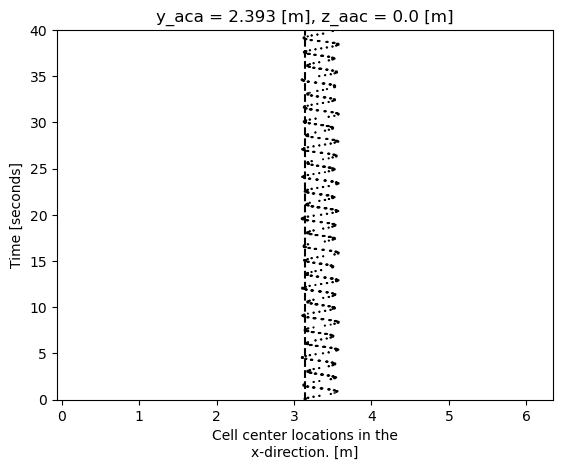

In [39]:
ds.T[:,0,100,:].plot.contour(levels=[0.999],colors='black')
plt.axvline(np.pi, color='black', linestyle='--', label='x = π')

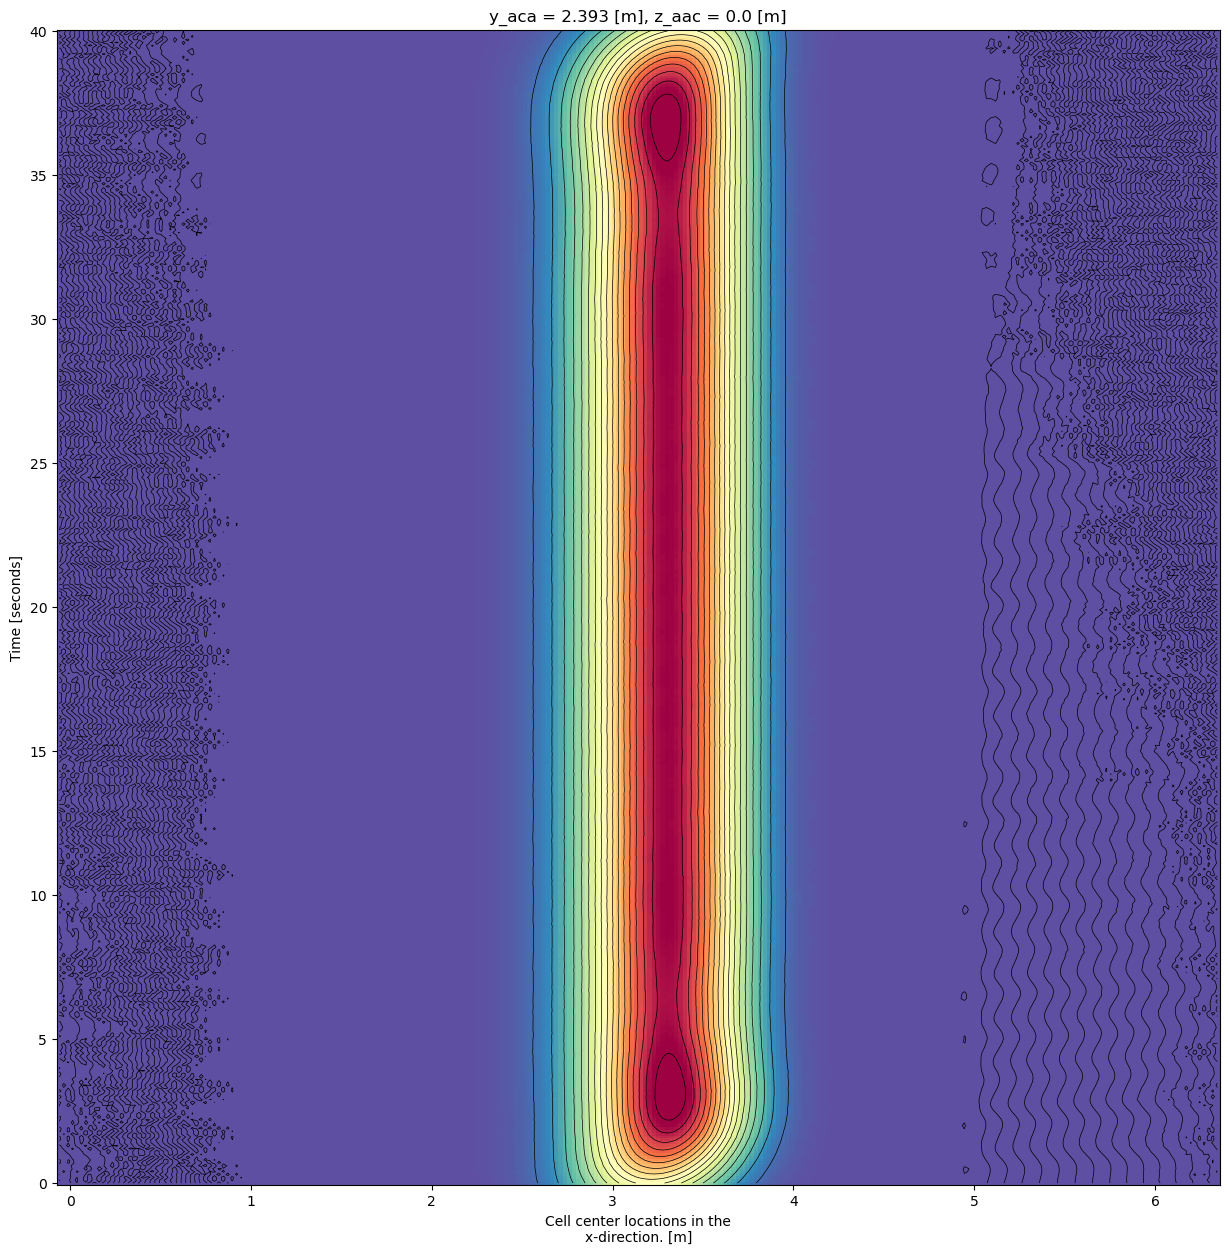

In [23]:
ds.T_filtered_regrid[:,0,100,:].plot(figsize = (15,15),vmin = 0, vmax = 1,add_colorbar=False,cmap='Spectral_r')
ds.T_filtered_regrid[:,0,100,:].plot.contour(levels=40,colors='black',linewidths=0.5)

In [16]:
Hx= ds.Hx.values
Hy= ds.Hy.values
x = ds.x_caa[Hx+1:-Hx]
y = ds.y_aca[Hy+1:-Hy]
dx = ds.dx_caa.values
dy = ds.dy_aca.values
Lx = ds.Lx.values
Ly = ds.Ly.values
npad = 2
for var_name in ['ω','T']:
    ds[var_name + '_filtered_regrid_python'] = ds.xi_u.copy(data=np.zeros_like(ds.xi_u.values))
    for it in tqdm(range(ds.time.shape[0])):
        ds_it = ds.isel({'time':it})
        mapxr = ds_it.xi_u[0,Hy+1:-Hy,Hx+1:-Hx] + x
        mapyr = ds_it.xi_v[0,Hy+1:-Hy,Hx+1:-Hx] + y
        xx_loc = (mapxr - ds_it.xi_u[0,Hy+1:-Hy,Hx+1:-Hx]) #trick to get meshgrid of x and y
        yy_loc = (mapyr - ds_it.xi_v[0,Hy+1:-Hy,Hx+1:-Hx])
        # x and y are periodic coordinate
        mapxr -= np.floor((mapxr - x[0]) / Lx) * Lx
        mapyr -= np.floor((mapyr - y[0]) / Ly) * Ly
        mapxr_ravel = np.ravel(mapxr)
        mapyr_ravel = np.ravel(mapyr)
        scalar_ravel = np.ravel(ds_it[var_name + '_filtered'][0,Hy+1:-Hy,Hx+1:-Hx])
        #Let's pad to avoid interpolation issues at the edges

        # First in x
        mapxr_extra_x = mapxr_ravel[(mapxr_ravel < dx*npad) | (mapxr_ravel > Lx - dx*npad) ]
        mapyr_extra_x = mapyr_ravel[(mapxr_ravel < dx*npad) | (mapxr_ravel > Lx - dx*npad) ]
        scalar_extra_x = scalar_ravel[(mapxr_ravel < dx*npad) | (mapxr_ravel > Lx - dx*npad) ]

        mapxr_extra_x[mapxr_extra_x < dx*npad] += Lx
        mapxr_extra_x[mapxr_extra_x > Lx - dx*npad] -= Lx
        
        mapxr_ravel = np.concatenate((mapxr_ravel, mapxr_extra_x))
        mapyr_ravel = np.concatenate((mapyr_ravel, mapyr_extra_x))
        scalar_ravel = np.concatenate((scalar_ravel, scalar_extra_x))

        # Now in y
        mapxr_extra_y = mapxr_ravel[(mapyr_ravel < dy*npad) | (mapyr_ravel > Ly - dy*npad) ]
        mapyr_extra_y = mapyr_ravel[(mapyr_ravel < dy*npad) | (mapyr_ravel > Ly - dy*npad) ]
        scalar_extra_y = scalar_ravel[(mapyr_ravel < dy*npad) | (mapyr_ravel > Ly - dy*npad) ]

        mapyr_extra_y[mapyr_extra_y < dy*npad] += Ly
        mapyr_extra_y[mapyr_extra_y > Ly - dy*npad] -= Ly
        
        mapxr_ravel = np.concatenate((mapxr_ravel, mapxr_extra_y))
        mapyr_ravel = np.concatenate((mapyr_ravel, mapyr_extra_y))
        scalar_ravel = np.concatenate((scalar_ravel, scalar_extra_y))



        interp = LinearNDInterpolator(list(zip(mapyr_ravel,mapxr_ravel)),np.ravel(scalar_ravel))
        ds[var_name + '_filtered_regrid_python'][it,0,Hy+1:-Hy,Hx+1:-Hx] = interp(yy_loc, xx_loc)

100%|██████████| 401/401 [03:30<00:00,  1.90it/s]


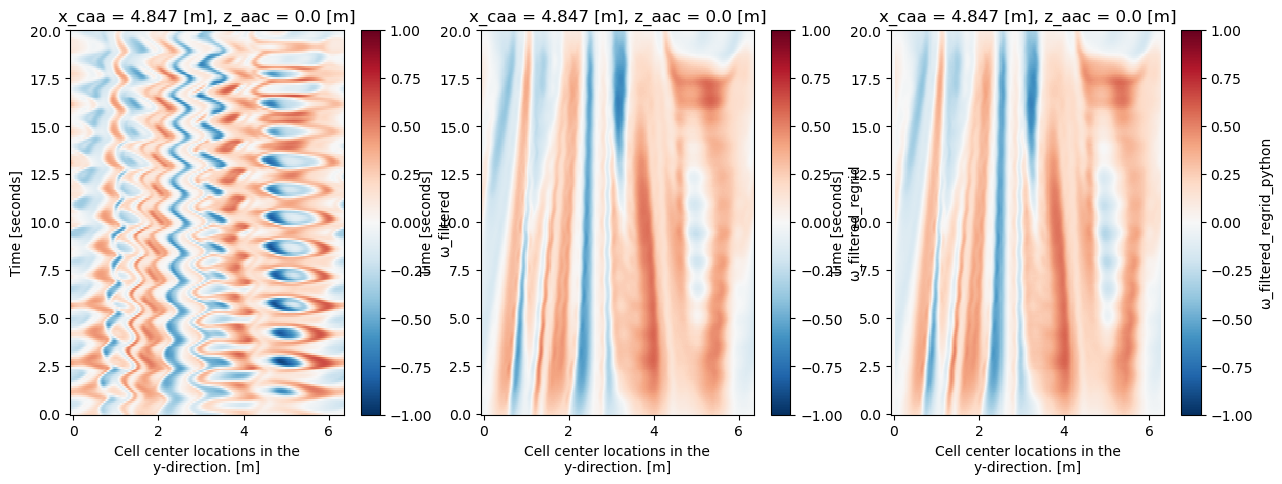

In [59]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))
ds.ω_filtered[:,0,:,200].plot(ax=ax[0],vmin = -1, vmax = 1, cmap= 'RdBu_r')
ds.ω_filtered_regrid[:,0,:,200].plot(ax=ax[1],vmin = -1, vmax = 1, cmap= 'RdBu_r')
ds.ω_filtered_regrid_python[:,0,:,200].plot(ax=ax[2],vmin = -1, vmax = 1, cmap= 'RdBu_r')
#ds.T_filtered_regrid[:,10,0,:].plot.contour(levels=40, colors='k', linewidths=0.5)

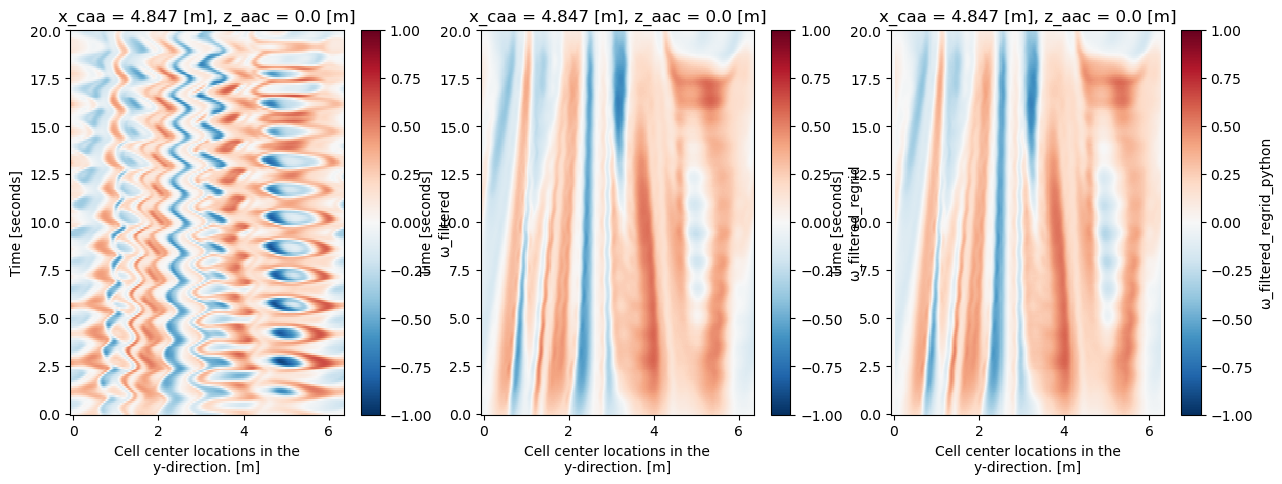

In [60]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))
ds.ω_filtered[:,0,:,200].plot(ax=ax[0],vmin = -1, vmax = 1, cmap= 'RdBu_r')
ds.ω_filtered_regrid[:,0,:,200].plot(ax=ax[1],vmin = -1, vmax = 1, cmap= 'RdBu_r')
ds.ω_filtered_regrid_python[:,0,:,200].plot(ax=ax[2],vmin = -1, vmax = 1, cmap= 'RdBu_r')
#ds.T_filtered_regrid[:,10,0,:].plot.contour(levels=40, colors='k', linewidths=0.5)

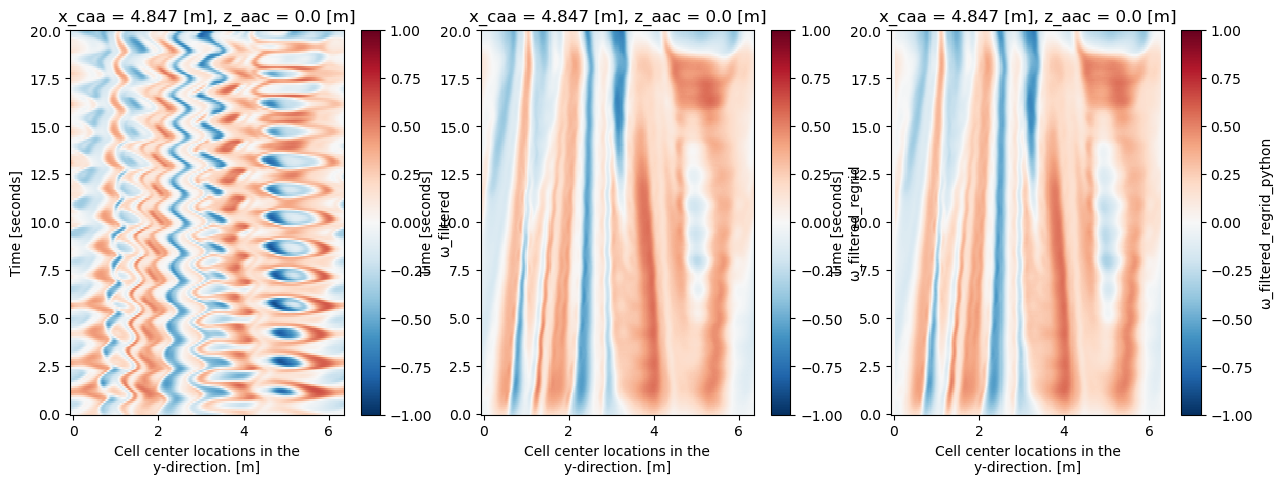

In [50]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))
ds.ω_filtered[:,0,:,200].plot(ax=ax[0],vmin = -1, vmax = 1, cmap= 'RdBu_r')
ds.ω_filtered_regrid[:,0,:,200].plot(ax=ax[1],vmin = -1, vmax = 1, cmap= 'RdBu_r')
ds.ω_filtered_regrid_python[:,0,:,200].plot(ax=ax[2],vmin = -1, vmax = 1, cmap= 'RdBu_r')

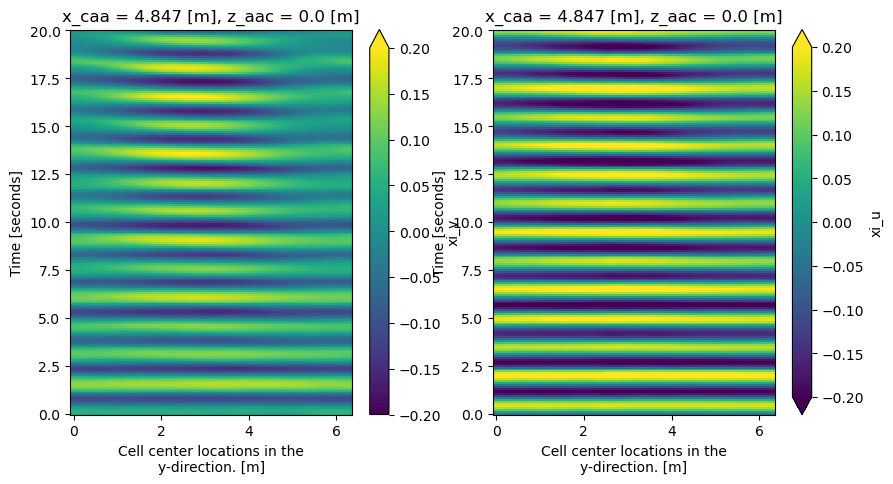

In [44]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
ds.xi_v[:,0,:,200].plot(ax=ax[0],vmin = -0.2, vmax = 0.2)
ds.xi_u[:,0,:,200].plot(ax=ax[1],vmin = -0.2, vmax = 0.2)

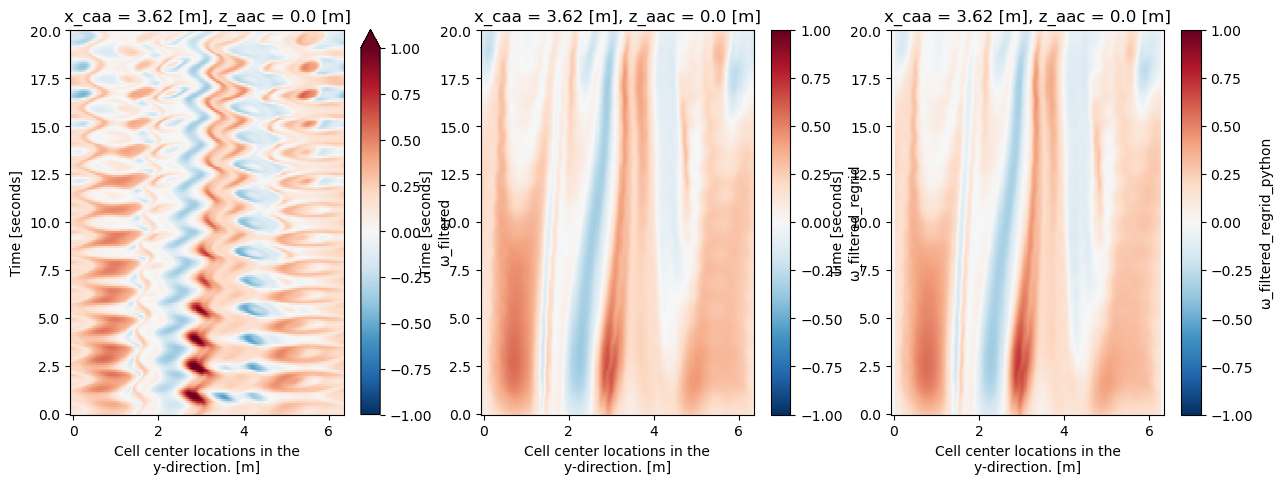

In [61]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))
ds.ω_filtered[:,0,:,150].plot(ax=ax[0],vmin = -1, vmax = 1, cmap= 'RdBu_r')
ds.ω_filtered_regrid[:,0,:,150].plot(ax=ax[1],vmin = -1, vmax = 1, cmap= 'RdBu_r')
ds.ω_filtered_regrid_python[:,0,:,150].plot(ax=ax[2],vmin = -1, vmax = 1, cmap= 'RdBu_r')
#ds.T_filtered_regrid[:,10,0,:].plot.contour(levels=40, colors='k', linewidths=0.5)

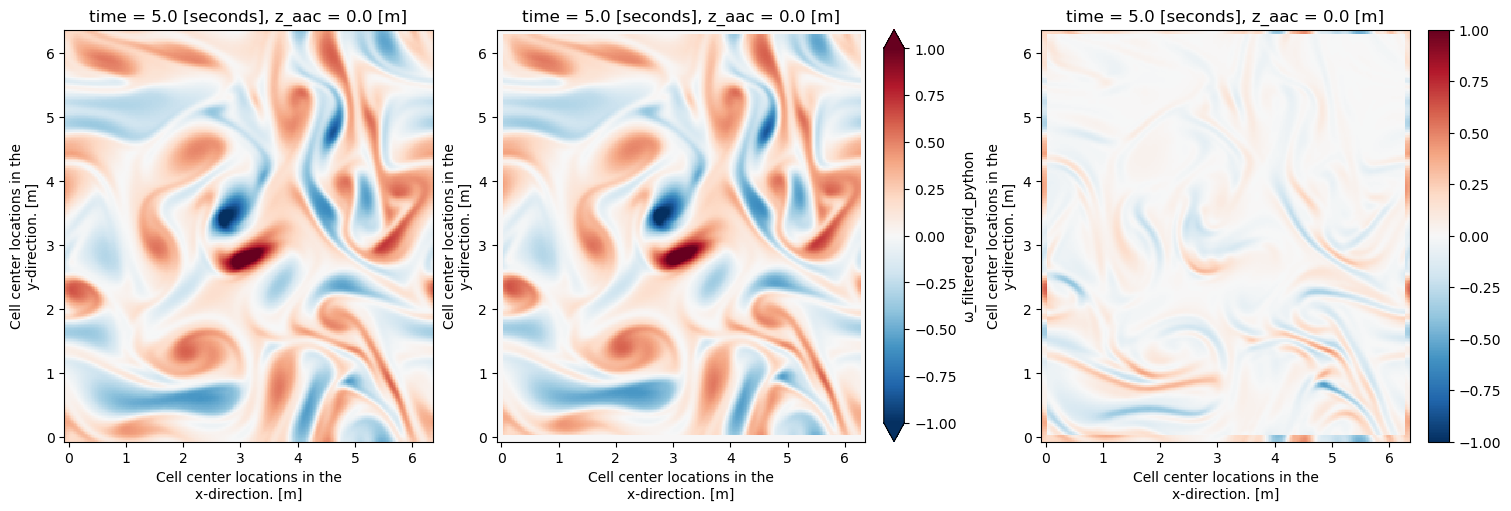

In [54]:
fig, ax = plt.subplots(1,3, figsize=(15, 5),constrained_layout=True)
#ds.ω_filtered[100,0,:,:].plot(ax=ax[0],vmin = -1, vmax = 1, cmap= 'RdBu_r',add_colorbar=False)
it=50
ds.ω_filtered_regrid[it,0,:,:].plot(ax=ax[0],vmin = -1, vmax = 1, cmap= 'RdBu_r',add_colorbar=False)
ds.ω_filtered_regrid_python[it,0,:,:].plot(ax=ax[1],vmin = -1, vmax = 1, cmap= 'RdBu_r')

(ds.ω_filtered_regrid - ds.ω_filtered_regrid_python)[it,0,:,:].plot(ax=ax[2],vmin = -1, vmax = 1, cmap= 'RdBu_r')

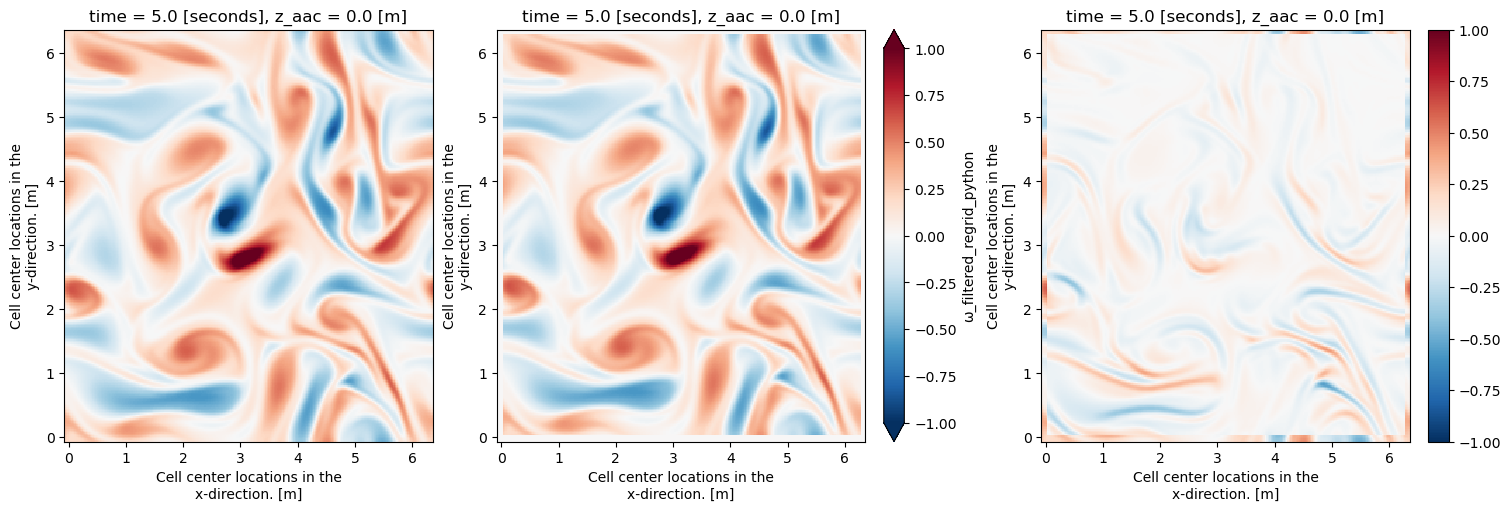

In [35]:
fig, ax = plt.subplots(1,3, figsize=(15, 5),constrained_layout=True)
#ds.ω_filtered[100,0,:,:].plot(ax=ax[0],vmin = -1, vmax = 1, cmap= 'RdBu_r',add_colorbar=False)
it=50
ds.ω_filtered_regrid[it,0,:,:].plot(ax=ax[0],vmin = -1, vmax = 1, cmap= 'RdBu_r',add_colorbar=False)
ds.ω_filtered_regrid_python[it,0,:,:].plot(ax=ax[1],vmin = -1, vmax = 1, cmap= 'RdBu_r')

(ds.ω_filtered_regrid - ds.ω_filtered_regrid_python)[it,0,:,:].plot(ax=ax[2],vmin = -1, vmax = 1, cmap= 'RdBu_r')

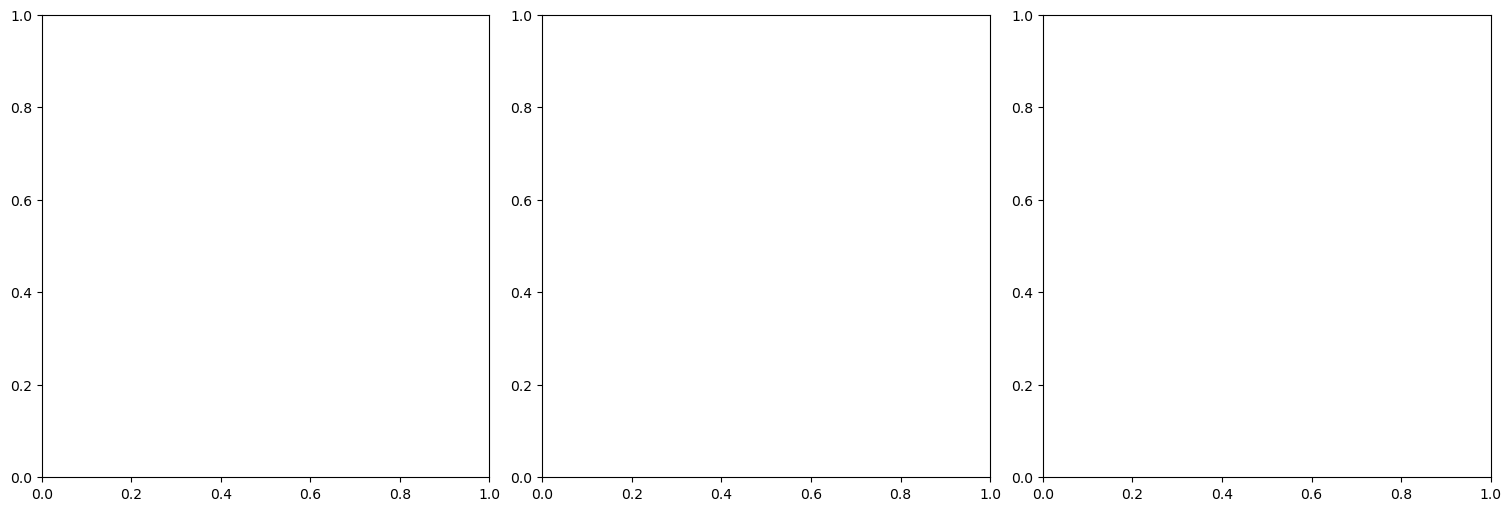

In [30]:
fig, ax = plt.subplots(1,3, figsize=(15, 5),constrained_layout=True)
#ds.ω_filtered[100,0,:,:].plot(ax=ax[0],vmin = -1, vmax = 1, cmap= 'RdBu_r',add_colorbar=False)
for it in range(201):
    fig, ax = plt.subplots(1,3, figsize=(15, 5),constrained_layout=True)
    ds.ω_filtered_regrid[it,0,:,:].plot(ax=ax[0],vmin = -1, vmax = 1, cmap= 'RdBu_r',add_colorbar=False)
    ds.ω_filtered_regrid_python[it,0,:,:].plot(ax=ax[1],vmin = -1, vmax = 1, cmap= 'RdBu_r',add_colorbar=False)

    (ds.ω_filtered_regrid - ds.ω_filtered_regrid_python)[it,0,:,:].plot(ax=ax[2],vmin = -1, vmax = 1, cmap= 'RdBu_r')
    fig.savefig(f"plots/python_julia_regrid_{it:03d}.png")
    plt.close()

In [31]:
import os
# Run ffmpeg command to make the plots. Change crf value for different file size, 23 default, 28 low quality, 21 higher quality, etc
os.system(f'ffmpeg -framerate 20 -start_number 0 -i ' + f'plots/python_julia_regrid_%03d.png -crf 23 -pix_fmt yuv420p ' + f'plots/my_movie.mp4')

# Could remove the plots (but might be worth keeping until you’re happy with the video)
#os.system('rm ' + f'plots/python_julia_regrid_*.png')

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


0